/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video

MAE on test data: 328540.5
MAPE on test data: 10.376
RMSE on test data: 833586.4


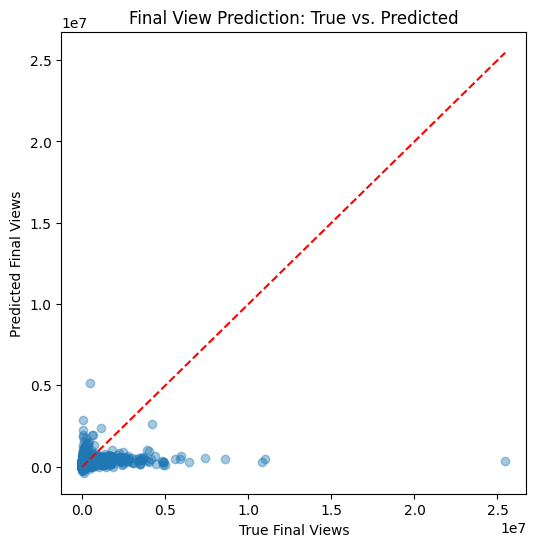

In [3]:
# LARM-Style Milestone-Based Prediction with Clustering
# (A sample Python notebook code)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# ----------------------------------------------
# 1. LOAD AND PREPARE DATA
# ----------------------------------------------
df = pd.read_csv("../data/Initial Engagement v1 - _WITH_videos_AS_get_the_videos_.csv")

# Example assumed columns:
#   views3s_1k, impressions_1k, like_1k, comments_1k
#   views3s_5k, impressions_5k, like_5k, comments_5k
#   views_final   (our target: final lifetime views)

# If your CSV has slightly different columns, rename them here accordingly:
# df.rename(columns={
#     'OldViews3s1K': 'views3s_1k',
#     'OldImpressions1K': 'impressions_1k',
#     ...
# }, inplace=True)

# Drop rows that have missing or obviously invalid data
df.dropna(subset=[
    'views3s_1k','impressions_1k','like_1k','comments_1k',
    'views3s_5k','impressions_5k','like_5k','comments_5k',
    'views_final'
], inplace=True)

# Filter out nonsensical or negative values, if any
df = df[(df['impressions_1k'] > 0) & (df['impressions_5k'] > 0)]

# ----------------------------------------------
# 2. FEATURE ENGINEERING
# ----------------------------------------------
# Create velocity features, ratios, etc.
# (Adjust these to suit your preference or domain knowledge)

df['vel_impr_1k5k'] = (df['impressions_5k'] - df['impressions_1k'])
df['vel_views3s_1k5k'] = (df['views3s_5k'] - df['views3s_1k'])
df['like_ratio_1k'] = df['like_1k'] / (df['impressions_1k'] + 1e-5)
df['like_ratio_5k'] = df['like_5k'] / (df['impressions_5k'] + 1e-5)
df['comment_ratio_1k'] = df['comments_1k'] / (df['impressions_1k'] + 1e-5)
df['comment_ratio_5k'] = df['comments_5k'] / (df['impressions_5k'] + 1e-5)

# We’ll treat these features as “early signals” for clustering:
clustering_features = [
    'vel_impr_1k5k', 'vel_views3s_1k5k',
    'like_ratio_1k', 'like_ratio_5k',
    'comment_ratio_1k', 'comment_ratio_5k'
]

# We’ll also define regression_features used by specialized models
# (including everything + impressions_1k, impressions_5k, etc.)
regression_features = [
    'impressions_1k','views3s_1k','like_1k','comments_1k',
    'impressions_5k','views3s_5k','like_5k','comments_5k',
    'vel_impr_1k5k','vel_views3s_1k5k',
    'like_ratio_1k','like_ratio_5k',
    'comment_ratio_1k','comment_ratio_5k'
]

# ----------------------------------------------
# 3. CLUSTER VIDEOS BY VELOCITY / EARLY SIGNALS
# ----------------------------------------------
# Choose a number of clusters (e.g., 3) to capture different growth/lifetime patterns
K = 3

# Standardize the clustering features for stable performance
X_cluster = df[clustering_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=K, random_state=42)
df['cluster_id'] = kmeans.fit_predict(X_scaled)

# ----------------------------------------------
# 4. TRAIN SPECIALIZED REGRESSORS PER CLUSTER
# ----------------------------------------------
# Our target = 'views_final'
# We'll do a train/test split on the entire dataset, but keep cluster info
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# We'll store one model per cluster
models = {}

for cluster_label in range(K):
    # Pull just the data for that cluster
    train_sub = train_df[train_df['cluster_id'] == cluster_label]

    # Defensive check: skip cluster if it's empty
    if len(train_sub) == 0:
        continue

    X_train = train_sub[regression_features]
    y_train = train_sub['views_final'].values

    # Train a simple linear regression (you can swap in XGB, LightGBM, etc.)
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Store the trained model
    models[cluster_label] = reg

# ----------------------------------------------
# 5. EVALUATE ON TEST DATA
# ----------------------------------------------
test_preds = []
test_truth = []

for idx, row in test_df.iterrows():
    cluster_id = row['cluster_id']
    # If the cluster is missing a trained model (shouldn't happen if all clusters have data),
    # fallback to the first cluster's model or skip
    if cluster_id not in models:
        # fallback or skip
        continue

    X_row = row[regression_features].values.reshape(1, -1)
    pred = models[cluster_id].predict(X_row)

    test_preds.append(pred[0])
    test_truth.append(row['views_final'])

mape = mean_absolute_percentage_error(test_truth, test_preds)
rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
mae = np.mean(np.abs(np.array(test_truth) - np.array(test_preds)))

print(f"MAE on test data: {mae:.1f}")
print(f"MAPE on test data: {mape:.3f}")
print(f"RMSE on test data: {rmse:.1f}")

# (Optional) Basic scatter comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(test_truth, test_preds, alpha=0.4)
plt.plot([0,max(test_truth)],[0,max(test_truth)],'r--')
plt.title("Final View Prediction: True vs. Predicted")
plt.xlabel("True Final Views")
plt.ylabel("Predicted Final Views")
plt.show()